In [1]:
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
data_path = "../data/Dataset/Motor vehicle insurance data.csv"
raw_data = pd.read_csv(data_path, delimiter=';')
raw_data.shape

(105555, 30)

In [3]:
raw_data.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190


# Analyze the data

## Drop column ID
the ID column is not needed for modeling

In [4]:
# raw_data.drop("ID", axis=1, inplace=True)

## Check Null Values
check null values in eaach column

In [5]:
raw_data.isnull().sum()

ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64

1. Date\_lapse (70,408 missing)

* What it means: No lapse has occurred. It’s not missing—it’s informative.
* Action: Replace missing with a flag:
  * Create new binary feature: has\_lapsed = 0 if missing, 1 if not.
  * May drop the actual Date\_lapse column.

2. Type\_fuel (1,764 missing)

* What it means: Fuel type was not registered or missing from source.
* Action: If small compared to total rows:
  * Option 1: Fill with mode ('D' or 'P')
  * Option 2: Create 'Unknown' category and label encode it

3. Length (10,329 missing)

* What it means: Vehicle length not available. This is a mechanical feature.
* Action:
  * If other vehicle dimensions (e.g. Power, Cylinder\_capacity, Weight) are present, can impute using a regression model.
  * If useless to predict, drop the column entirely.
* Do not drop rows unless model shows Length adds significant signal.

✅ What to do next

* Engineer binary features like has\_lapsed.
* For Length, do an experiment: run two versions of the model (with/without it) and check if it helps.
  * If it does, keep it and consider use a regression model to impute missing values.
  * If not, drop it.

## check data variation

In [6]:
for column in raw_data.columns:
        print(column, ":", raw_data[column].unique())

ID : [    1     2     3 ... 53500 53501 53502]
Date_start_contract : ['05/11/2015' '26/09/2017' '29/11/2013' ... '13/11/2010' '10/08/2014'
 '17/08/2011']
Date_last_renewal : ['05/11/2015' '05/11/2016' '05/11/2017' ... '19/03/2016' '19/03/2017'
 '19/03/2018']
Date_next_renewal : ['05/11/2016' '05/11/2017' '05/11/2018' ... '19/03/2017' '19/03/2018'
 '19/03/2019']
Date_birth : ['15/04/1956' '18/03/1975' '10/07/1973' ... '18/10/1949' '24/02/1955'
 '29/12/1992']
Date_driving_licence : ['20/03/1976' '10/07/1995' '05/07/1993' ... '06/10/2007' '23/10/2014'
 '29/11/2017']
Distribution_channel : [0 1]
Seniority : [ 4 15  3 13 18  6 19 10 20  1  2  5  9  7  8 12 17 11 16 22 14 39 27 34
 21 25 24 28 40 33 29 26 32 31 23 30 36 35 37 38]
Policies_in_force : [ 1  2  3  4  5  8  6  9 10 14  7 12 11 13 15 17 16]
Max_policies : [ 2  1  3  4  5  8  6  9  7 10 14 12 11 13 15 17 16]
Max_products : [1 2 3 4]
Lapse : [0 1 2 3 4 5 6 7]
Date_lapse : [nan '11/02/2017' '24/10/2017' ... '26/03/2019' '27/01/2019' 

🟨 Columns that Require Conversion

1. Type\_fuel → Categorical: 'P', 'D'
   
   Convert to integer:
   * 'P' → 0
   * 'D' → 1
   * If include 'Unknown' → 2 if imputing missing.

2. Date columns (must be transformed):

   * Date\_start\_contract
   * Date\_last\_renewal
   * Date\_next\_renewal
   * Date\_birth
   * Date\_driving\_licence
   * Date\_lapse

These need to be converted to datetime objects and engineered into features:

New features:

* contract\_duration = Date\_next\_renewal − Date\_start\_contract
* age = Date\_start\_contract − Date\_birth
* licence\_years = Date\_start\_contract − Date\_driving\_licence
* lapse\_flag = 1 if Date\_lapse not null else 0

Then can drop raw date columns.

# Transform the data

In [7]:
transform_data = copy.deepcopy(raw_data)

## Date related features

In [8]:
# Convert date strings to datetime objects
transform_data["Date_start_contract"] = pd.to_datetime(transform_data["Date_start_contract"], format='%d/%m/%Y')
transform_data["Date_last_renewal"] = pd.to_datetime(transform_data["Date_last_renewal"], format='%d/%m/%Y')
transform_data["Date_next_renewal"] = pd.to_datetime(transform_data["Date_next_renewal"], format='%d/%m/%Y')
transform_data["Date_birth"] = pd.to_datetime(transform_data["Date_birth"], format='%d/%m/%Y')
transform_data['Date_driving_licence'] = pd.to_datetime(transform_data['Date_driving_licence'], format='%d/%m/%Y')

### Contract duration
Date_next_renewal - Date_start _contract

In [9]:
# Calculate contract duration in years
transform_data["contract_duration"] = ((transform_data["Date_next_renewal"] - transform_data["Date_start_contract"]).dt.days)/365.25

### Age
Date_start_contract - Date_birth

In [10]:
# Calculate age in years
transform_data['age'] = ((transform_data['Date_next_renewal'] - transform_data['Date_birth']).dt.days)/365.25

### Licence duration
Date_start_contract - Date_driving_licence

In [11]:
# Calculate license duration in years
transform_data['licence_duration'] = ((transform_data['Date_start_contract'] - transform_data['Date_driving_licence']).dt.days)/365.25

### Bool values for Lapse
in_lapse = 1 if Date_lapse not null else 0

In [12]:
transform_data['in_lapse'] = transform_data['Date_lapse'].notna().astype(int)

## categorical
Type\_fuel → Categorical: 'P', 'D' to 0, 1

left the empty values as it is

In [13]:
# Create a mapping dictionary
fuel_type_map = {'P': 0, 'D': 1}

# Replace values using map and fillna
transform_data['Type_fuel'] = transform_data['Type_fuel'].map(fuel_type_map)

# Try fill the empty data

In [14]:
filled_data = copy.deepcopy(transform_data)

## type_fuel

In [15]:
# Create feature matrix for non-null Type_fuel rows

features = ['Type_risk', 'Value_vehicle', 'Power', 'Cylinder_capacity', 'N_doors', 'Weight']
X = filled_data[~filled_data['Type_fuel'].isna()][features]
y = filled_data[~filled_data['Type_fuel'].isna()]['Type_fuel']

# Split the data and train a classification model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict Type_fuel for rows with missing values
missing_fuel_mask = filled_data['Type_fuel'].isna()
X_predict = filled_data[missing_fuel_mask][features]
predicted_fuel = model.predict(X_predict)

# Fill missing values with predictions
filled_data.loc[missing_fuel_mask, 'Type_fuel'] = predicted_fuel

## length

In [16]:
# Create feature matrix for non-null Length rows
features = ['Power', 'Cylinder_capacity', 'Weight', 'Type_risk', 'N_doors', 'Type_fuel',]
X = filled_data[~filled_data['Length'].isna()][features]
y = filled_data[~filled_data['Length'].isna()]['Length']

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict Length for rows with missing values
missing_length_mask = filled_data['Length'].isna()
X_predict = filled_data[missing_length_mask][features]
predicted_lengths = model.predict(X_predict)

# Fill missing values with predictions
filled_data.loc[missing_length_mask, 'Length'] = predicted_lengths

# Round to 3 decimal places to match the existing data format
filled_data['Length'] = filled_data['Length'].round(3)

# Visualization distribution

In [17]:
def visualize_data(data):
    """
    Visualizes the data by plotting the distribution of each numerical column.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to visualize.
    """
    # Set up the figure size for better visibility
    plt.figure(figsize=(20, 15))

    # Get numerical columns (excluding date columns)
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

    # Create subplots for each numerical column
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(7, 7, i)
        sns.histplot(data=data, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

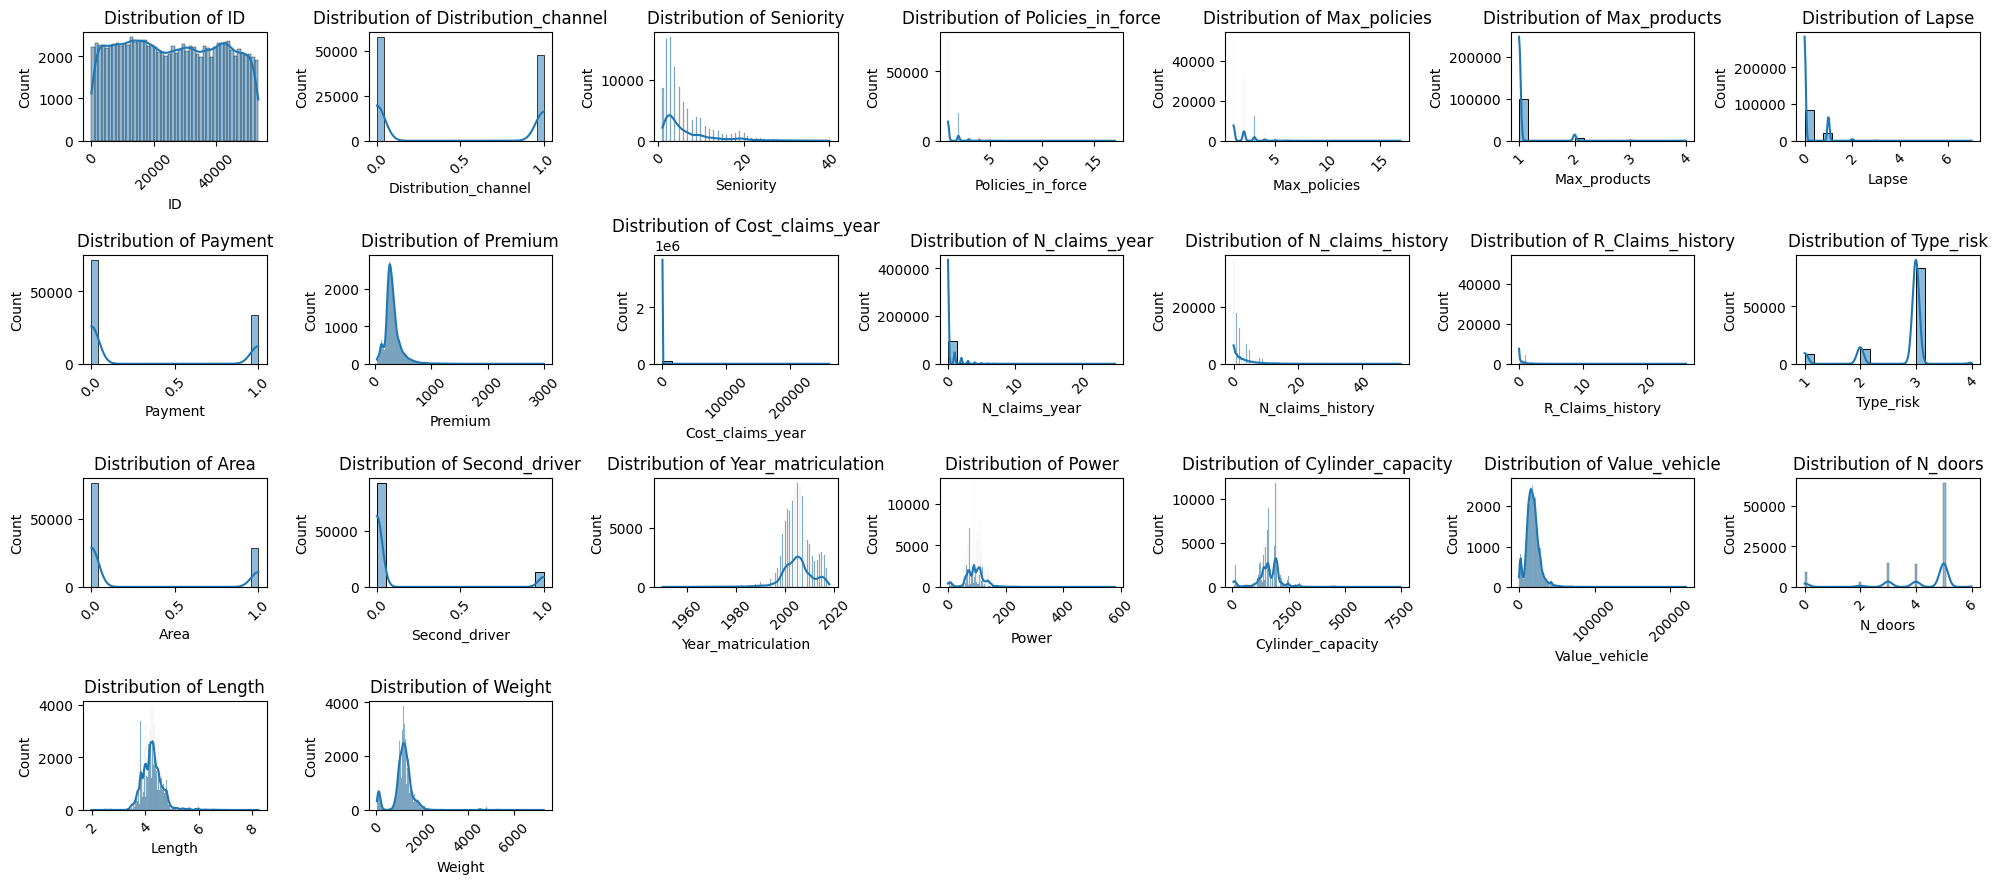

In [18]:
visualize_data(raw_data)

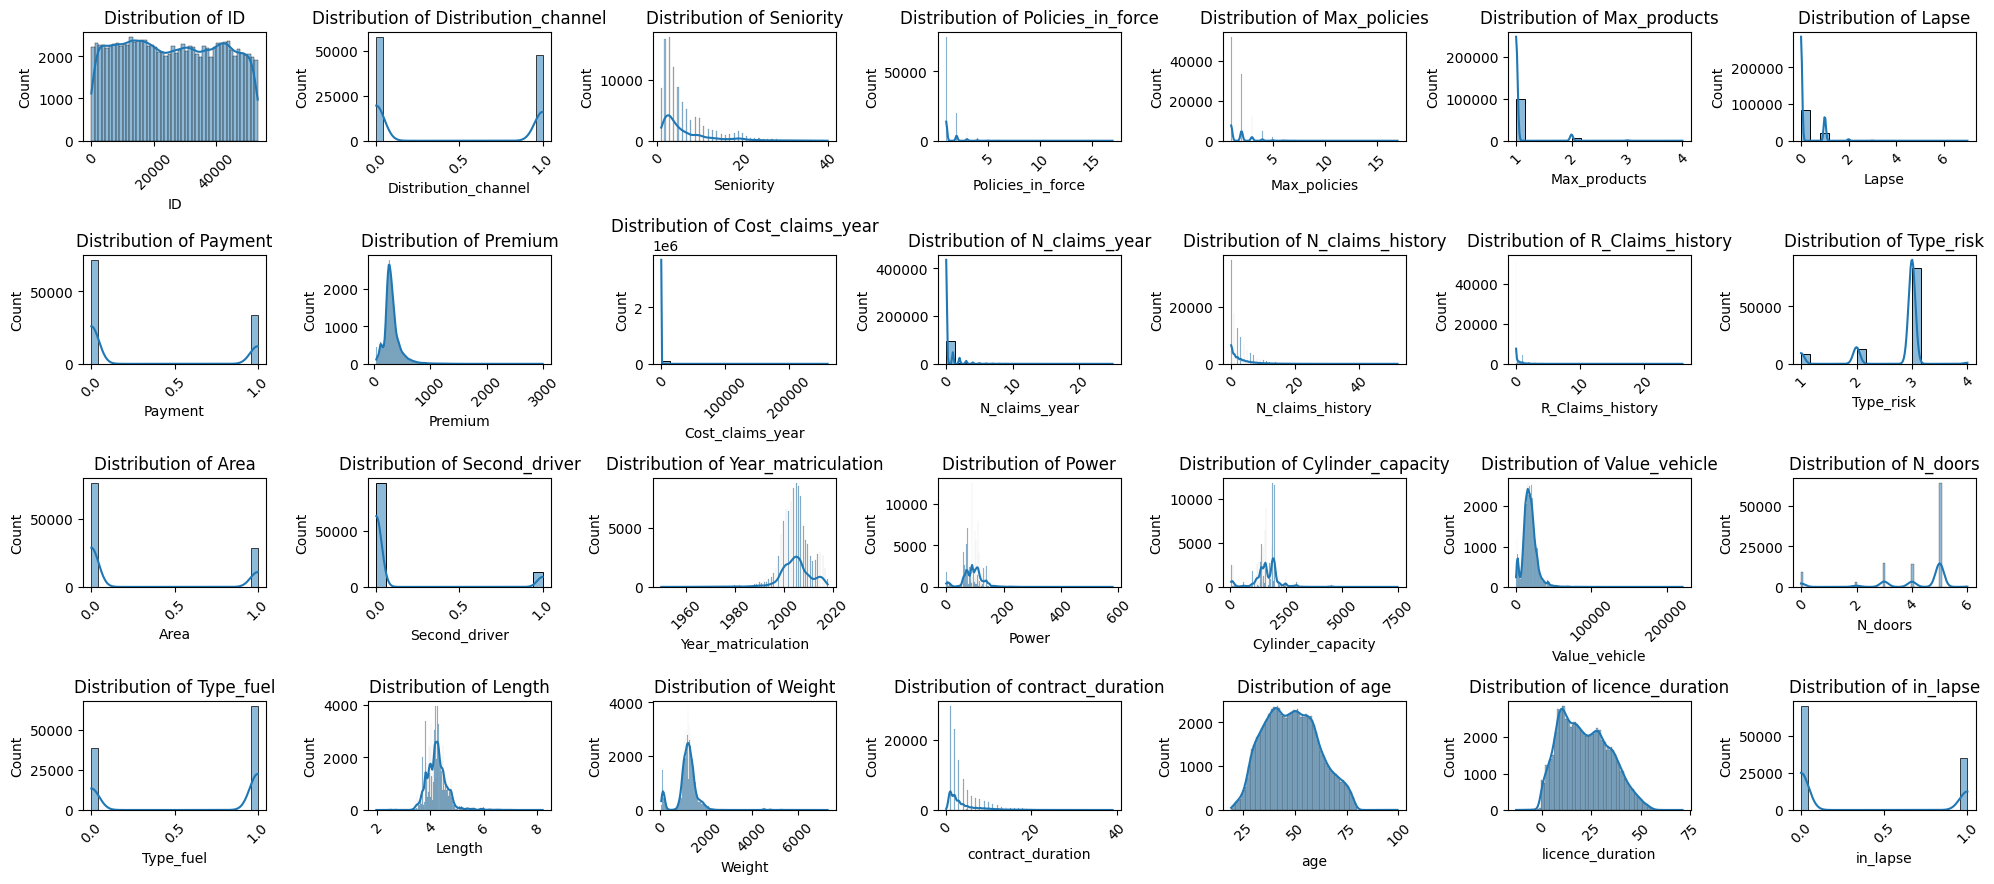

In [19]:
visualize_data(transform_data)

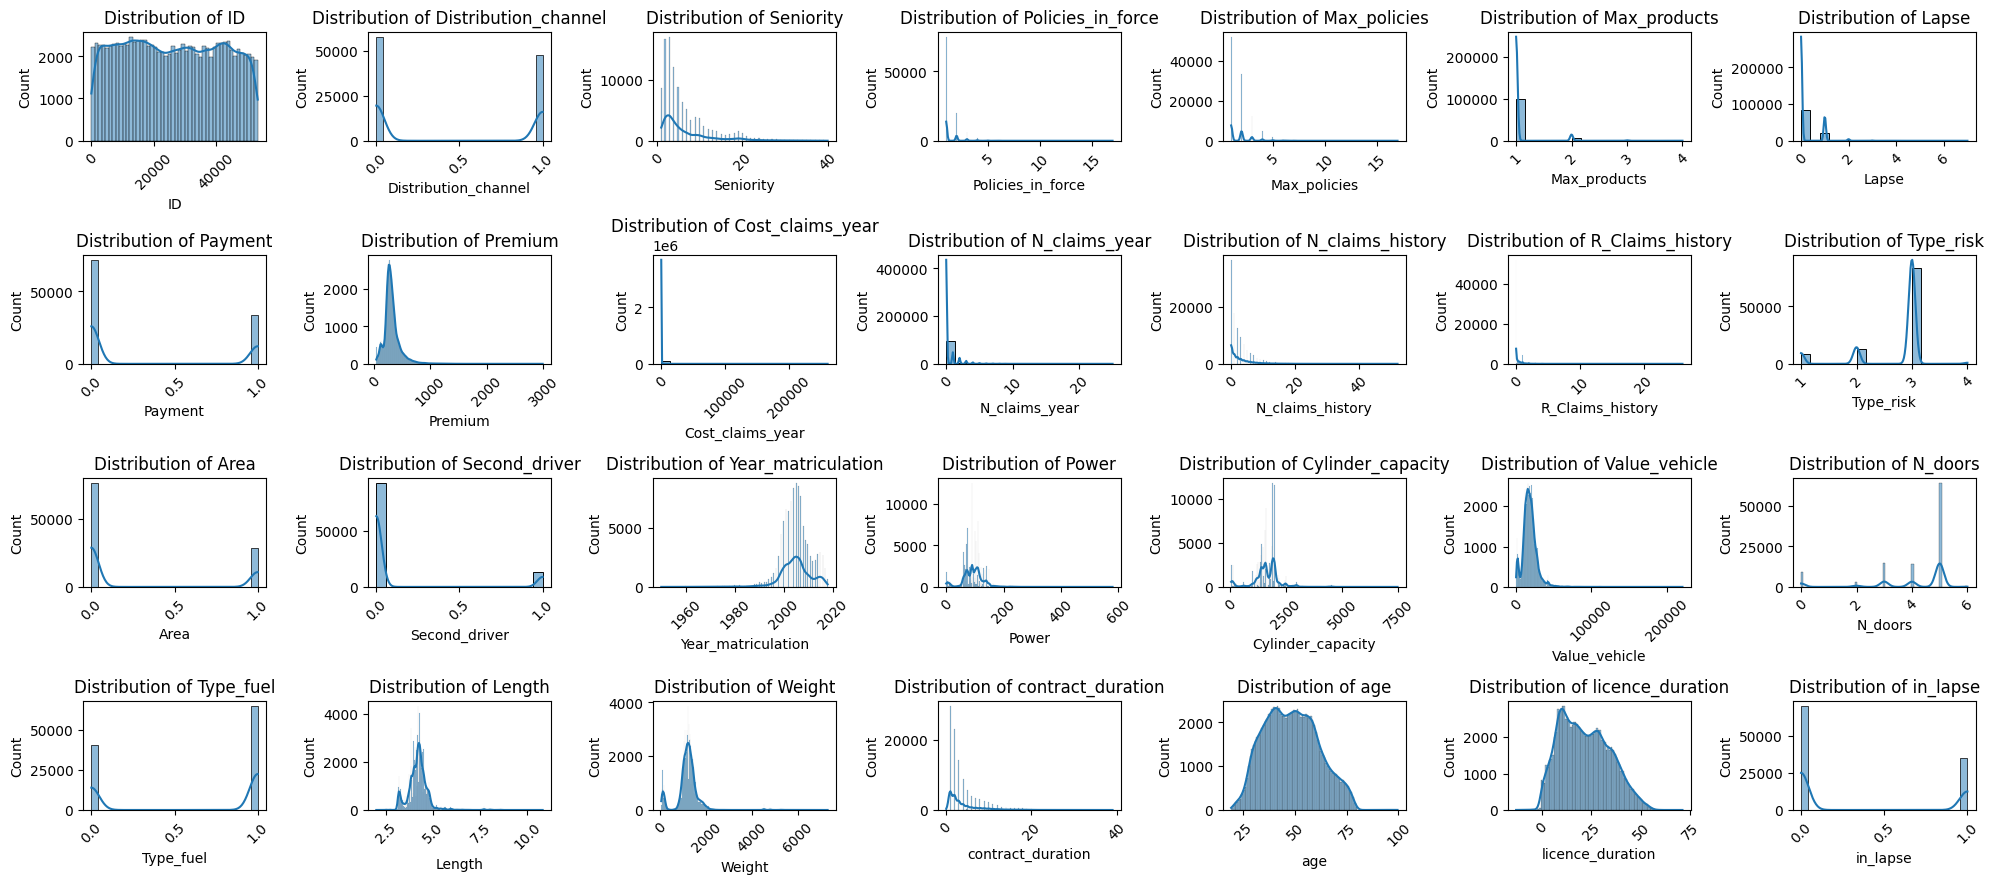

In [20]:
visualize_data(filled_data)

# Feature Engineering

## N_claims_year

In [21]:
N_claims_year_value_list = filled_data['N_claims_year'].unique().tolist()
print(N_claims_year_value_list)

N_claims_year_dict = {}
for i in N_claims_year_value_list:
    N_claims_year_dict[i] = 0


for i in filled_data['N_claims_year']:
    N_claims_year_dict[i] += 1

for i in N_claims_year_dict:
    N_claims_year_dict[i] = round(N_claims_year_dict[i] / len(filled_data) * 100, 2)
    
print(N_claims_year_dict)

[0, 3, 8, 4, 1, 2, 9, 7, 6, 5, 15, 13, 10, 11, 14, 12, 18, 19, 17, 25, 21, 16]
{0: 81.39, 3: 2.31, 8: 0.13, 4: 1.13, 1: 9.04, 2: 4.7, 9: 0.08, 7: 0.22, 6: 0.3, 5: 0.58, 15: 0.01, 13: 0.02, 10: 0.06, 11: 0.02, 14: 0.01, 12: 0.02, 18: 0.0, 19: 0.0, 17: 0.0, 25: 0.0, 21: 0.0, 16: 0.0}


81.39% never file a claim.

The data is imbalanced.

create "has_claim" column

In [22]:
filled_data['has_claim'] = filled_data['N_claims_year'].apply(lambda x: 1 if x > 0 else 0)

## Ratio Features
to expose behavior

### Premium / Value_vehicle
Tells how much the customer pays relative to their car’s worth. High ratio? Might be high risk or overcharged.

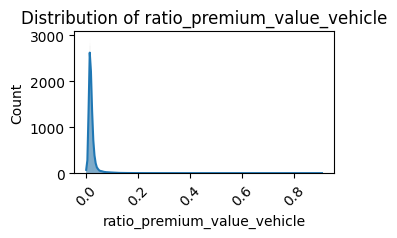

In [23]:
filled_data['ratio_premium_value_vehicle'] = filled_data['Premium'] / filled_data['Value_vehicle']

visualize_data(filled_data[['ratio_premium_value_vehicle']])

In [24]:
print(filled_data['ratio_premium_value_vehicle'].describe())

count    105555.000000
mean          0.021691
std           0.019569
min           0.000652
25%           0.013523
50%           0.017618
75%           0.023595
max           0.908415
Name: ratio_premium_value_vehicle, dtype: float64


max 90% of car value? Insane. Check is it data error or not.

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,N_doors,Type_fuel,Length,Weight,contract_duration,age,licence_duration,in_lapse,has_claim,ratio_premium_value_vehicle
2247,1140,2015-12-23,2015-12-23,2016-12-23,1970-12-08,1990-05-01,1,2,2,2,...,4,1.0,4.042,995,1.002053,46.042437,25.645448,1,0,0.320483
2248,1140,2015-12-23,2016-12-23,2017-12-23,1970-12-08,1990-05-01,1,2,2,2,...,4,1.0,4.042,995,2.001369,47.041752,25.645448,1,0,0.330095
5090,2511,2016-02-12,2016-02-12,2017-02-12,1967-11-27,1986-07-10,0,6,3,3,...,3,0.0,4.240,1350,1.002053,49.212868,29.593429,0,0,0.582461
5091,2511,2016-02-12,2017-02-12,2018-02-12,1967-11-27,1986-07-10,0,6,3,3,...,3,0.0,4.240,1350,2.001369,50.212183,29.593429,0,0,0.599942
5092,2511,2016-02-12,2018-02-12,2019-02-12,1967-11-27,1986-07-10,0,6,3,3,...,3,0.0,4.240,1350,3.000684,51.211499,29.593429,0,0,0.602982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,48065,2018-07-02,2018-07-02,2019-07-02,1997-05-03,2018-05-12,0,1,1,1,...,0,0.0,3.129,60,0.999316,22.162902,0.139630,0,0,0.294854
98644,49629,2018-05-31,2018-05-31,2019-05-31,1993-02-14,2016-04-20,0,1,1,1,...,0,0.0,3.148,77,0.999316,26.288843,2.110883,0,0,0.227008
98957,49798,2012-07-19,2016-07-19,2017-07-19,1953-03-07,1976-05-17,0,5,1,4,...,0,0.0,3.122,55,4.999316,64.366872,36.172485,1,0,0.202039
102248,51592,2017-01-05,2017-01-05,2018-01-05,1958-06-01,2000-02-01,1,2,1,1,...,2,0.0,3.322,600,0.999316,59.597536,16.928131,0,0,0.372309


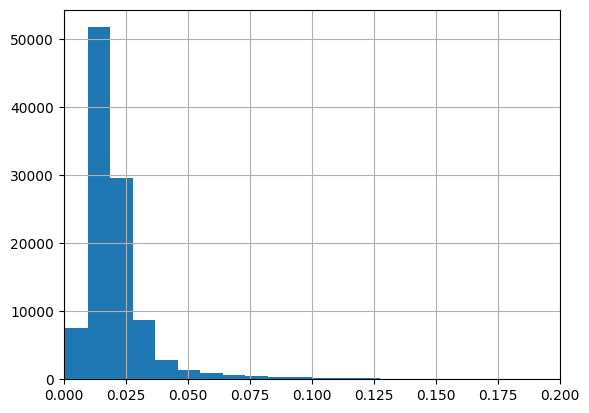

In [25]:
filled_data['ratio_premium_value_vehicle'].hist(bins=100)
plt.xlim(0, 0.2) # Cut out the tail to focus on bulk

filled_data[filled_data['ratio_premium_value_vehicle'] > 0.2] # These people are paying 20%+ of vehicle value.

In [26]:
filled_data['log1p_ratio_pv'] = np.log1p((filled_data['Premium'] / filled_data['Value_vehicle']).clip(upper=0.1))
print(filled_data['log1p_ratio_pv'].describe())

count    105555.000000
mean          0.020807
std           0.013795
min           0.000651
25%           0.013432
50%           0.017465
75%           0.023320
max           0.095310
Name: log1p_ratio_pv, dtype: float64


### Cost_claims_year / Premium
If this is consistently >1, company losing money

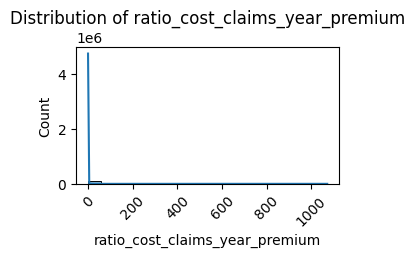

In [27]:
filled_data["ratio_cost_claims_year_premium"] = filled_data["Cost_claims_year"] / filled_data["Premium"]
visualize_data(filled_data[['ratio_cost_claims_year_premium']])

In [28]:
print(filled_data['ratio_cost_claims_year_premium'].describe())

count    105555.000000
mean          0.476172
std           4.720622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1071.248039
Name: ratio_cost_claims_year_premium, dtype: float64


compress outliers with log1p and clip it

In [29]:
filled_data['cap_log1p_ratio_cost_claims_year_premium'] = np.log1p(filled_data["Cost_claims_year"] / filled_data["Premium"] + 1e-6)
filled_data['cap_log1p_ratio_cost_claims_year_premium'] = np.clip(filled_data['cap_log1p_ratio_cost_claims_year_premium'], 0, filled_data['cap_log1p_ratio_cost_claims_year_premium'].quantile(0.99))

print(filled_data['cap_log1p_ratio_cost_claims_year_premium'].describe())

count    1.055550e+05
mean     1.526853e-01
std      4.160148e-01
min      9.999995e-07
25%      9.999995e-07
50%      9.999995e-07
75%      9.999995e-07
max      2.203699e+00
Name: cap_log1p_ratio_cost_claims_year_premium, dtype: float64


many people not claimed their insurance.
The data is clean and clip worked well.
will use this feature

### N_claims_history / Seniority
need to normalize data to expose consistent overclaimers

In [30]:
filled_data['ratio_N_claims_history_Seniority'] = filled_data['N_claims_history'] / filled_data['Seniority']
print(filled_data['ratio_N_claims_history_Seniority'].describe())

count    105555.000000
mean          0.486834
std           0.805368
min           0.000000
25%           0.000000
50%           0.250000
75%           0.666667
max          33.000000
Name: ratio_N_claims_history_Seniority, dtype: float64


compress outliers with clip and log1p 

In [31]:
filled_data['log1p_cap_ratio_N_claims_history_Seniority'] = (filled_data['N_claims_history'] / filled_data['Seniority']).clip(upper=filled_data['N_claims_history'].quantile(0.99))
filled_data['log1p_cap_ratio_N_claims_history_Seniority'] = np.log1p(filled_data['log1p_cap_ratio_N_claims_history_Seniority'])
print(filled_data['log1p_cap_ratio_N_claims_history_Seniority'].describe())

count    105555.000000
mean          0.317322
std           0.359416
min           0.000000
25%           0.000000
50%           0.223144
75%           0.510826
max           2.890372
Name: log1p_cap_ratio_N_claims_history_Seniority, dtype: float64


if needed change to 

In [32]:
# Create bins for ratio of claims history to seniority
def assign_claim_freq_bin(ratio):
    if ratio == 0:
        return 0  # No claims ever
    elif ratio <= 0.25:
        return 1  # Low frequency 
    elif ratio <= 1.0:
        return 2  # Medium frequency
    else:
        return 3  # High frequency

filled_data['log1p_cap_ratio_N_claims_history_Seniority'] = filled_data['log1p_cap_ratio_N_claims_history_Seniority'].apply(assign_claim_freq_bin)
print(filled_data['log1p_cap_ratio_N_claims_history_Seniority'].describe())

count    105555.000000
mean          1.187684
std           0.975983
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: log1p_cap_ratio_N_claims_history_Seniority, dtype: float64


In [33]:
filled_data['ratio_Cost_claims_year_Premium '] = filled_data['Cost_claims_year'] / filled_data['Premium']
print(filled_data['ratio_Cost_claims_year_Premium '].describe())

count    105555.000000
mean          0.476172
std           4.720622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1071.248039
Name: ratio_Cost_claims_year_Premium , dtype: float64


# visualize new filled data


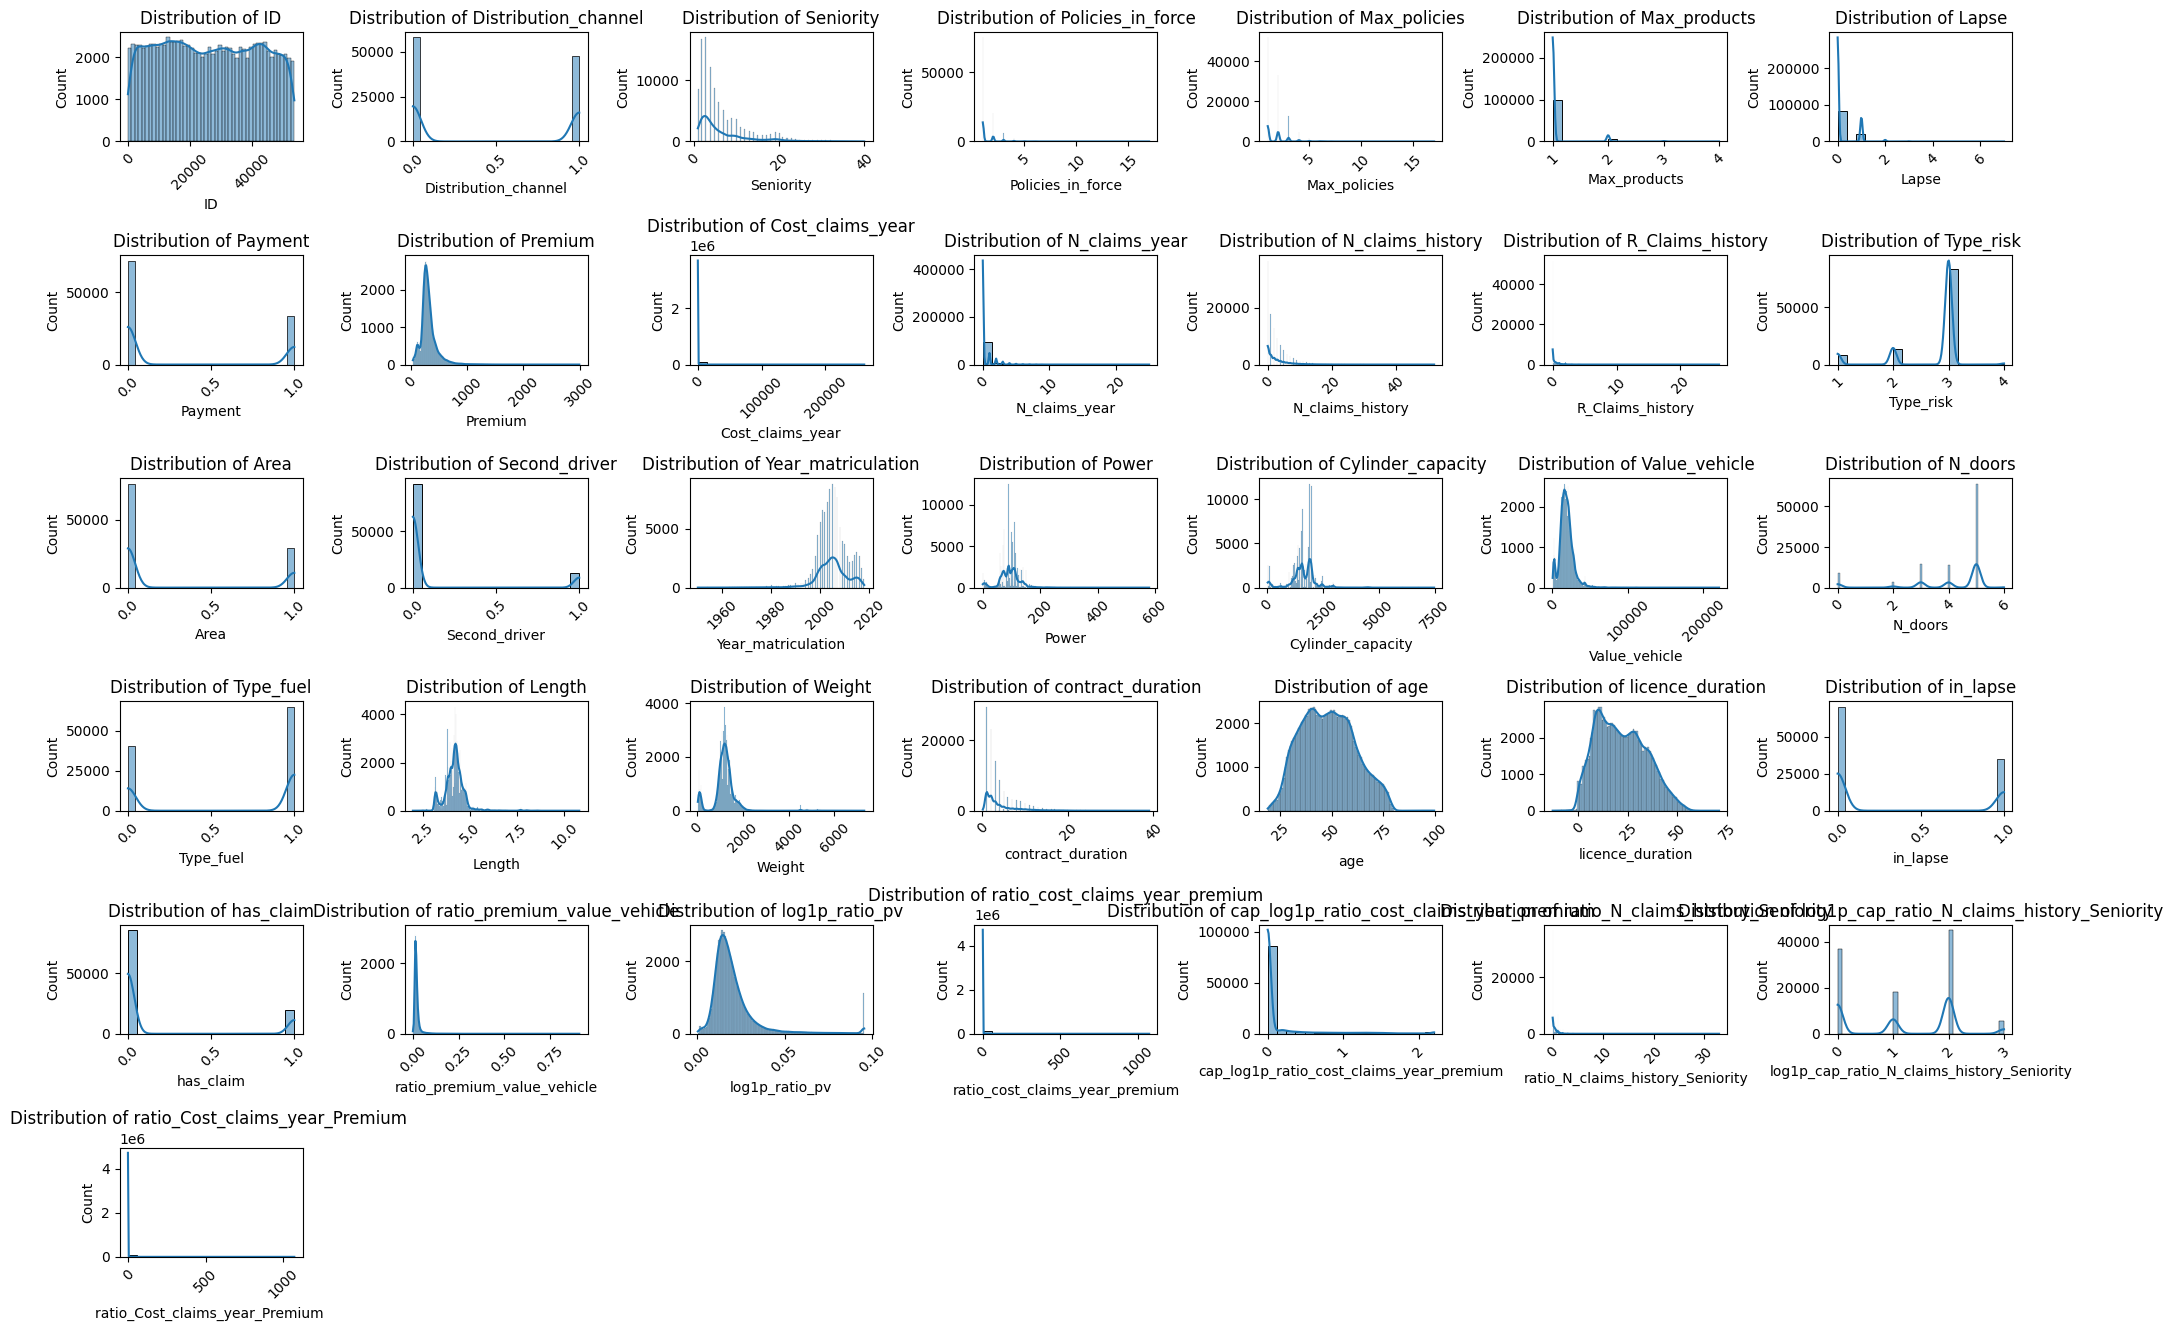

ID : [    1     2     3 ... 53500 53501 53502]
Date_start_contract : <DatetimeArray>
['2015-11-05 00:00:00', '2017-09-26 00:00:00', '2013-11-29 00:00:00',
 '2016-10-21 00:00:00', '2017-05-12 00:00:00', '2006-05-29 00:00:00',
 '2015-02-11 00:00:00', '2001-05-28 00:00:00', '2013-10-24 00:00:00',
 '2017-01-13 00:00:00',
 ...
 '2008-09-24 00:00:00', '2006-10-13 00:00:00', '2006-11-15 00:00:00',
 '2009-04-10 00:00:00', '2011-09-25 00:00:00', '2008-01-03 00:00:00',
 '2008-07-28 00:00:00', '2010-11-13 00:00:00', '2014-08-10 00:00:00',
 '2011-08-17 00:00:00']
Length: 5518, dtype: datetime64[ns]
Date_last_renewal : <DatetimeArray>
['2015-11-05 00:00:00', '2016-11-05 00:00:00', '2017-11-05 00:00:00',
 '2018-11-05 00:00:00', '2017-09-26 00:00:00', '2018-09-26 00:00:00',
 '2015-11-29 00:00:00', '2016-11-29 00:00:00', '2017-11-29 00:00:00',
 '2018-11-29 00:00:00',
 ...
 '2017-08-16 00:00:00', '2017-08-19 00:00:00', '2018-06-17 00:00:00',
 '2016-10-12 00:00:00', '2015-12-07 00:00:00', '2018-08-19 00

In [34]:
visualize_data(filled_data)
for column in filled_data.columns:
        print(column, ":", filled_data[column].unique())